# Source Localization using Distributed Sensors
 **(Final version will read directly from Pyserial and data will be collected at higher sampling rate)**

The first thing I need is a position matrix for all the sensors. The reason to start from a position matrix and not a distance matrix is because this algorithm can be adapted to a scenario where the sensors are not in a static position. I will record those positions in a dictionary using as relative position the position of sensor 1.

In [3]:
%%html
<img src="sensors.jpg" alt="Drawing" style="width: 500px;" align= "middle">

In [ ]:
import numpy as np
import scipy
from matplotlib import pyplot
from scipy import signal
from collections import deque
from multiprocessing import Pool
import mlpy.wavelet

In [ ]:
def R_dictionary(sensor, Hash):
    Hash.update(sensor)

#Growing my Position dictionary:
Hash={}
k=0
for j in np.array([0, 15, 30, 45]):
    for i in np.array([0, 10, 20]):
        k=k+1
        R_dictionary({k: [j, i]}, Hash)
print(Hash)

Now, I want to create a relative distance matrix by computing the Euclidean distance between each sensor. 

In [ ]:
Rel_Pos= np.zeros((len(Hash), len(Hash)))
for i in  np.arange(len(Hash)):
    for j in np.arange(len(Hash)):
        Rel_Pos[i][j]= ((Hash[i+1][0] - Hash[j+1][0])**2 + (Hash[i+1][1] - Hash[j+1][1])**2)**(1./2.)
pyplot.spy(Rel_Pos)
pyplot.show()

TO DO:
* ~~ Import the data and parse it~~
* Make a routine that decomposes the signal at level 1: s= a1+d1
* Use d1 to determine if there is an event if there is no event, don't do anything. If there is an event, fire the algorithm and record the time in which the event happened (t!)
* With the data identify the ones that got highest frequency at t!
* Assign probabilities to each sensor
* Do the triangulization method

In [85]:
def Event(sensor):
    # Module for Anomaly Detection
    # For CSCI 5363, I will use a Discrete Wavelet Transform for this module using the Fast Wavelet Transform Algorithm
    # I only care about the level 1 decomposition's second coefficient (d1) in  s= a1+d1 to identify whether there is an event or not
    # For CNN purposes, this module will be equivalent to the convolutional layer in a neural network
    widths = np.arange(1, 31)
    sensor= np.array(sensor)
    cwtmatr = signal.cwt(sensor.astype(int), signal.ricker, widths)
    pyplot.imshow(cwtmatr)
    pyplot.show()
    #return yesno

def SourceLoc(s1, s2, s3):
    # This is the actual routine that will do the source localization given three sensors and time of arrival
    
    return local

def Breeding(all_sensors):
    #This function will be called by each sensor every time there is an event in order
    #to be paired with two of the fittest sensors to make the guess of the source localization
    return bleh

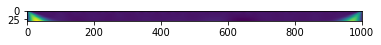

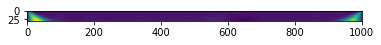

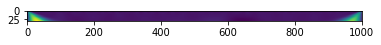

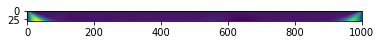

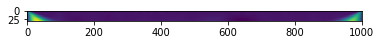

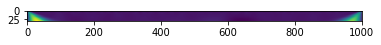

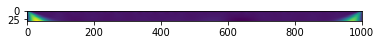

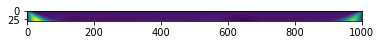

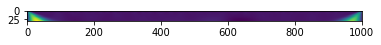

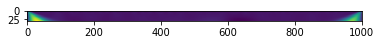

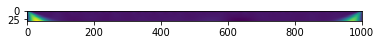

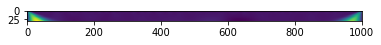

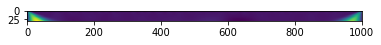

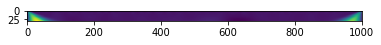

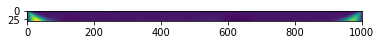

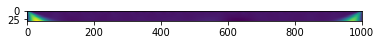

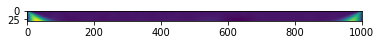

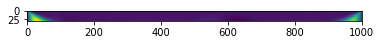

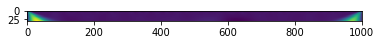

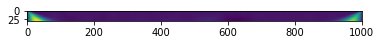

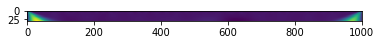

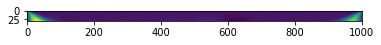

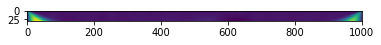

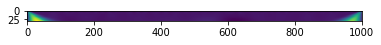

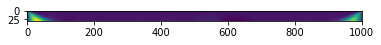

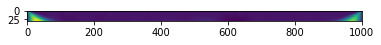

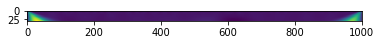

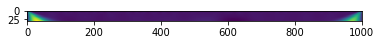

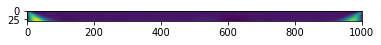

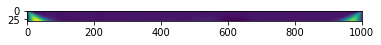

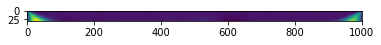

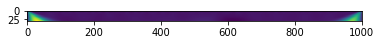

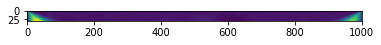

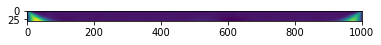

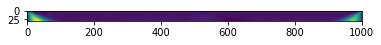

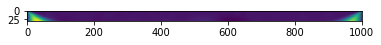

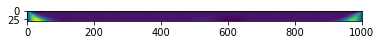

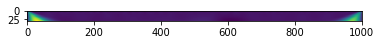

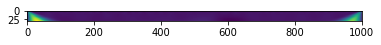

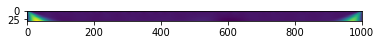

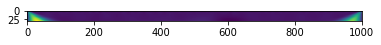

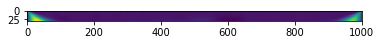

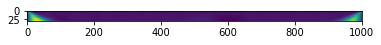

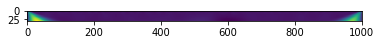

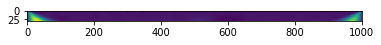

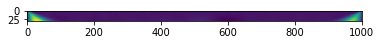

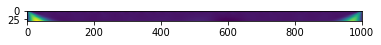

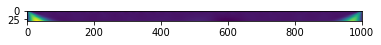

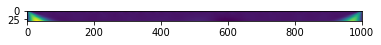

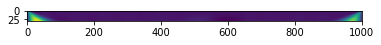

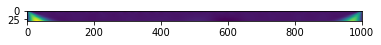

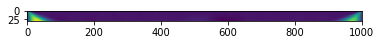

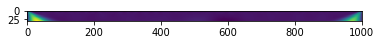

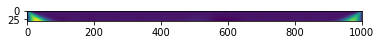

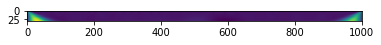

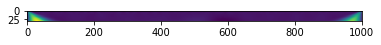

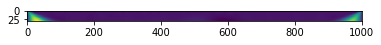

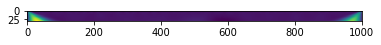

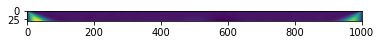

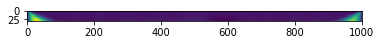

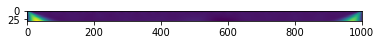

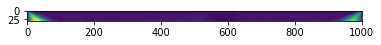

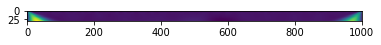

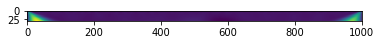

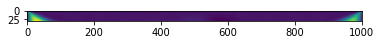

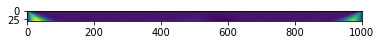

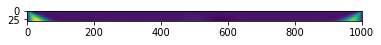

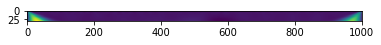

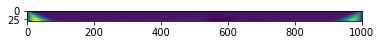

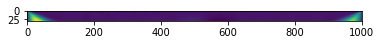

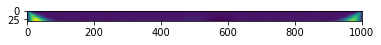

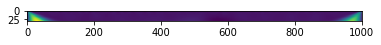

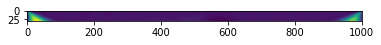

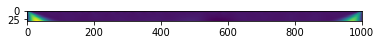

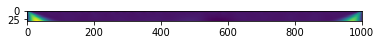

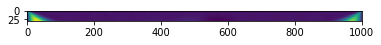

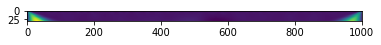

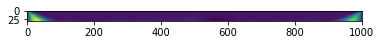

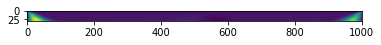

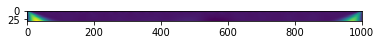

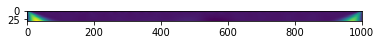

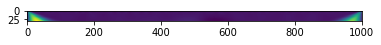

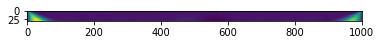

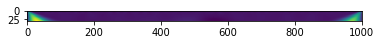

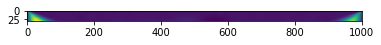

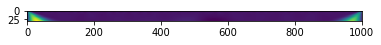

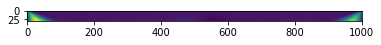

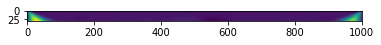

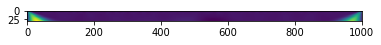

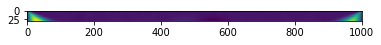

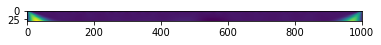

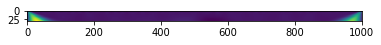

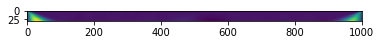

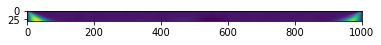

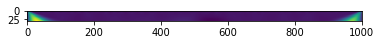

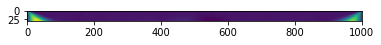

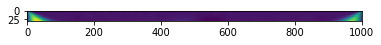

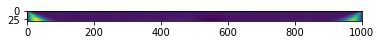

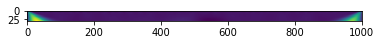

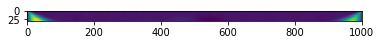

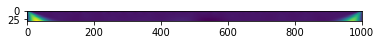

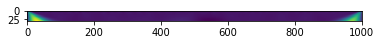

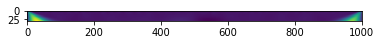

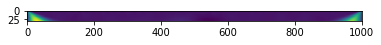

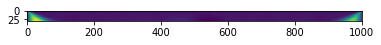

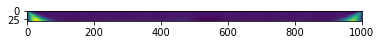

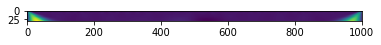

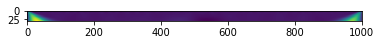

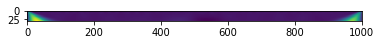

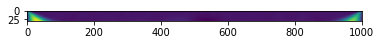

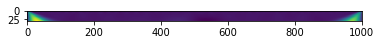

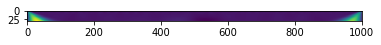

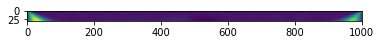

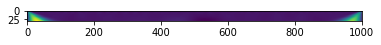

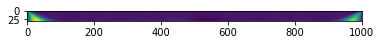

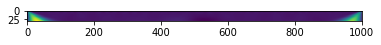

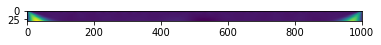

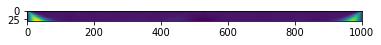

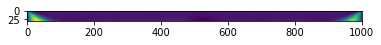

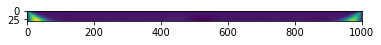

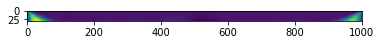

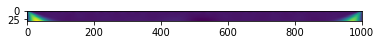

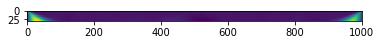

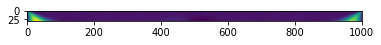

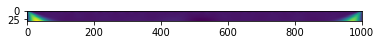

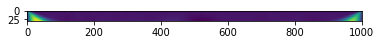

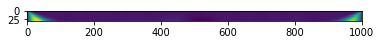

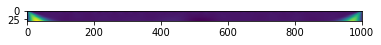

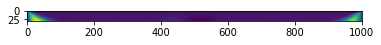

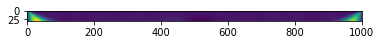

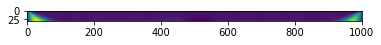

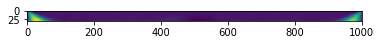

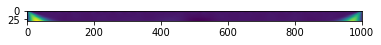

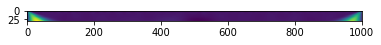

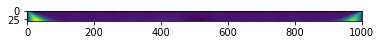

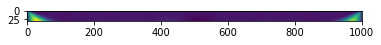

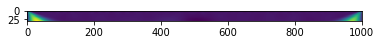

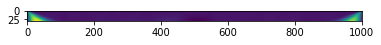

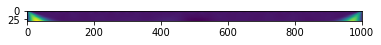

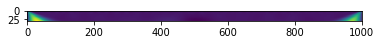

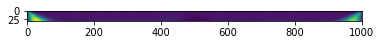

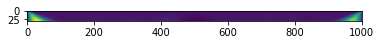

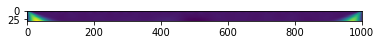

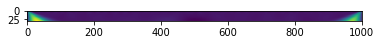

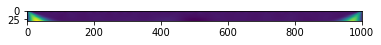

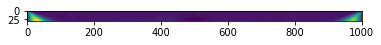

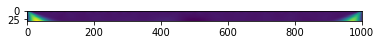

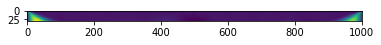

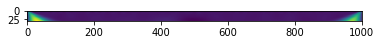

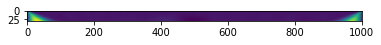

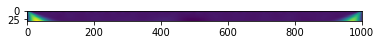

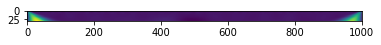

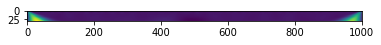

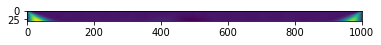

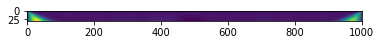

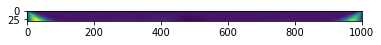

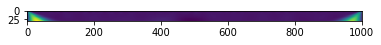

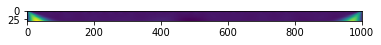

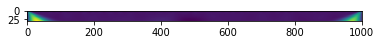

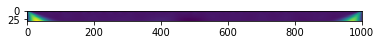

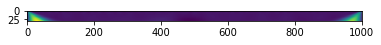

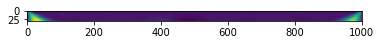

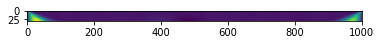

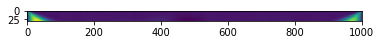

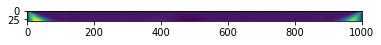

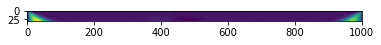

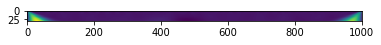

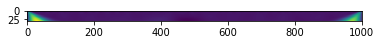

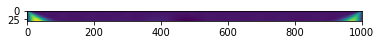

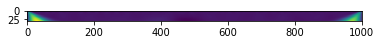

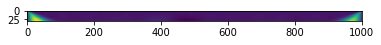

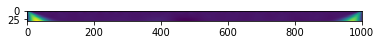

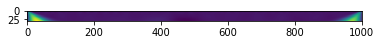

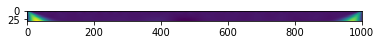

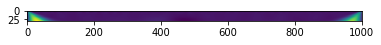

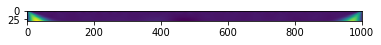

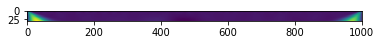

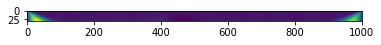

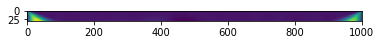

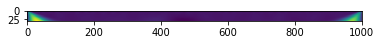

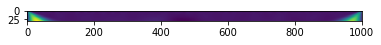

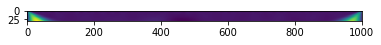

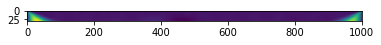

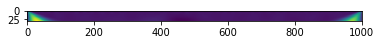

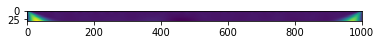

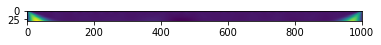

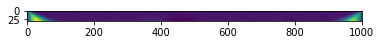

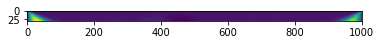

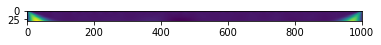

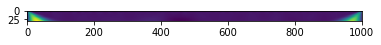

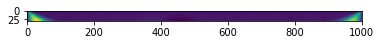

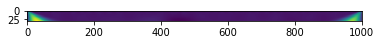

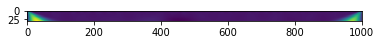

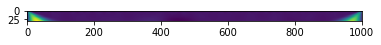

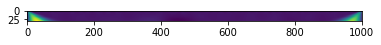

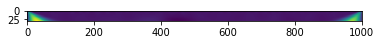

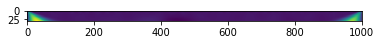

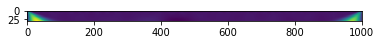

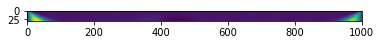

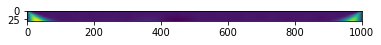

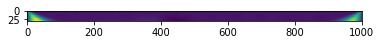

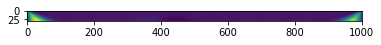

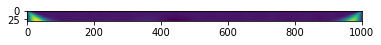

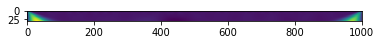

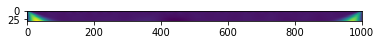

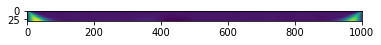

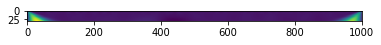

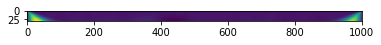

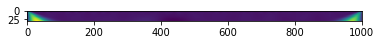

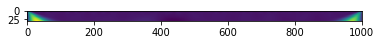

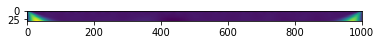

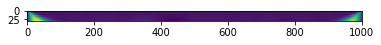

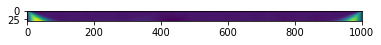

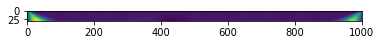

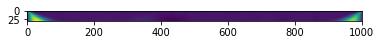

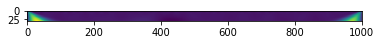

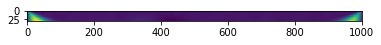

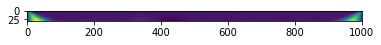

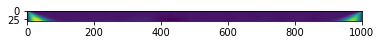

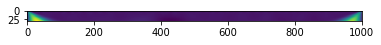

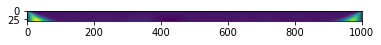

In [ ]:
f= 'Data1st.txt' #just importing data from touch in a single point with different forces
# This dataset has the peculiarity that I only touched the same spot ten times, therefore, my estimations should
# be close to those coordinates.
window_size= 1000
Window1= deque([])
Window2= deque([])
Window3= deque([])
Window4= deque([])
Window5= deque([])
Window6= deque([])
j=0
# Each line is a time stamp. 
# The sampling rate at which this data was taken is 400 Hz and the goal is 1kHz

with open(f) as file: #this loop will be replaced by some pyserial readline instruction if a life demo were to be done
    for line in file:
        data, timestamp = line.split("-")
        Sensors= data.split(",")
        
        #Because this is a simulation of the "big picture", I am going to use 6 deques:
        Sensors1=Sensors[0]
        Sensors2=Sensors[1]
        Sensors3=Sensors[2]
        Sensors4=Sensors[3]
        Sensors5=Sensors[4]
        Sensors6=Sensors[5]
        if j<=window_size:    
            Window1.append(Sensors1)
            Window2.append(Sensors2)
            Window3.append(Sensors3)
            Window4.append(Sensors4)
            Window5.append(Sensors5)
            Window6.append(Sensors6)
            j= j+1
        else:
            Window1.append(Sensors1)
            Window2.append(Sensors2)
            Window3.append(Sensors3)
            Window4.append(Sensors4)
            Window5.append(Sensors5)
            Window6.append(Sensors6)
            Window1.popleft()
            Window2.popleft()
            Window3.popleft()
            Window4.popleft()
            Window5.popleft()
            Window6.popleft()  
            
# Now that the windows are ready, I will send them to the Event function and if most of the sensors agree
# that there is an event, then the GA pairing part will act.
        if j>= window_size:
            Event(Window1)
 #   yn2= Event(Window2)
 #   yn3= Event(Window3)
 #   yn4= Event(Window4)
 #   yn5= Event(Window5)
 #   yn6= Event(Window6)
    
        # work from here to localize the source
        #yesno= Event(Window, sensor_index)